In [4]:
# Importing reqiured Libraries

import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [24]:
import tensorflow as tf

In [6]:
# Loading Dataset
data = pd.read_csv('amazon_alexa.tsv',sep='\t')
# Creating a new column sentiment based on overall ratin

def sentiments(df):
    if df['rating'] >3.0:
        return 'Positive'
    elif df['rating'] <= 3.0:
        return 'Negative'
    
data['sentiment'] = data.apply(sentiments, axis=1)

In [7]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [8]:
# Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [10]:
def cleaning(df, stop_words):
    # Converting to lowercase
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
                        ' '.join(x.lower() for x in x.split()))
    
    # Replacing the digit/numbers
    
    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')
    
    # Removing stop words
    
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
                        ' '.join(x for x in x.split() if x not in stop_words))
    
    # Lemmatization
    
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
                        ' '.join([Word(x).lemmatize() for x in x.split()]))
    
    return df


stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)    
    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12696\883138851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12696\883138851.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12696\883138851.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [11]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


<function matplotlib.pyplot.show(close=None, block=None)>

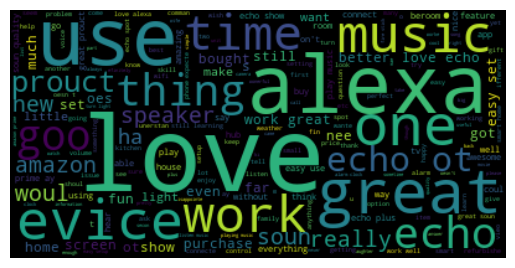

In [13]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [14]:
# Encoded the target column
lb = LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12696\2786440786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])


In [15]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1


In [25]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
#X = pad_sequences(X)

In [26]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [27]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 319, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 319, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# Splitting the data into training and testing

y = pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [29]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
batch_size = 32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 1)

Epoch 1/5
69/69 [==============================] - 77s 1s/step - loss: 0.3877 - accuracy: 0.8739
Epoch 2/5
69/69 [==============================] - 73s 1s/step - loss: 0.3065 - accuracy: 0.8816
Epoch 3/5
69/69 [==============================] - 73s 1s/step - loss: 0.2426 - accuracy: 0.9043
Epoch 4/5
69/69 [==============================] - 74s 1s/step - loss: 0.2119 - accuracy: 0.9156
Epoch 5/5
69/69 [==============================] - 73s 1s/step - loss: 0.1832 - accuracy: 0.9306


In [31]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 5s 122ms/step - loss: 0.2698 - accuracy: 0.8910


[0.2697768807411194, 0.891005277633667]

In [34]:
model.metrics_names

['loss', 'accuracy']

In [38]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))
     

Epoch 1/10
69/69 [==============================] - 78s 1s/step - loss: 0.1907 - accuracy: 0.9279 - val_loss: 0.2848 - val_accuracy: 0.8646
Epoch 2/10
69/69 [==============================] - 82s 1s/step - loss: 0.1565 - accuracy: 0.9410 - val_loss: 0.2701 - val_accuracy: 0.8974
Epoch 3/10
69/69 [==============================] - 85s 1s/step - loss: 0.1458 - accuracy: 0.9442 - val_loss: 0.3050 - val_accuracy: 0.8868
Epoch 4/10
69/69 [==============================] - 83s 1s/step - loss: 0.1351 - accuracy: 0.9474 - val_loss: 0.3255 - val_accuracy: 0.9016
Epoch 5/10
69/69 [==============================] - 82s 1s/step - loss: 0.1226 - accuracy: 0.9542 - val_loss: 0.2934 - val_accuracy: 0.8995
Epoch 6/10
69/69 [==============================] - 89s 1s/step - loss: 0.1221 - accuracy: 0.9519 - val_loss: 0.3255 - val_accuracy: 0.8921
Epoch 7/10
69/69 [==============================] - 80s 1s/step - loss: 0.1033 - accuracy: 0.9583 - val_loss: 0.3174 - val_accuracy: 0.9111
Epoch 8/10
69/69 [==

In [39]:
model.save('amazon_alexa_LSTM_model.h5')  

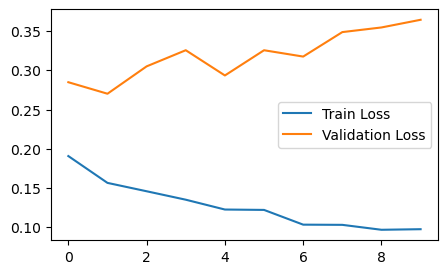

In [40]:

plt.figure(figsize=(5,3))
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()

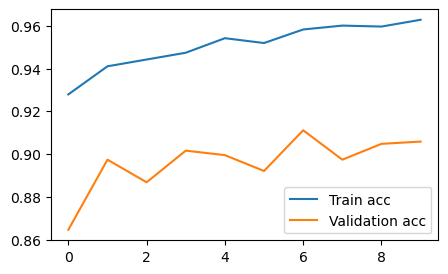

In [41]:
plt.figure(figsize=(5,3))
plt.plot(model.history.history['accuracy'], label='Train acc')
plt.plot(model.history.history['val_accuracy'], label='Validation acc')
plt.legend()

In [46]:
import keras

In [47]:
model = keras.models.load_model('amazon_alexa_LSTM_model.h5')